# ICNet

ICNet提供了一個real-time的Semantic Segmentation Network。雖然速度不如SegNet, ENet, SQ一樣快，但在mIoU上表現出較高的準確率。
主要貢獻:
1. 同時低resoultion的圖像中保有細節，且在高resolution的圖像中維持效能
2. 相較於PSPNet50(baseline)提高了五倍的速度和五分之一倍的memory消耗
3. 在Cityscapes, CamVid and COCO-Stuff等datset上皆提供了real-time inference的表現


#### Environment:
   - Ubuntu 18.04
   - Tensorflow 2.0 (stable)
   - CUDA 10.0
   - Cudnn 7.6.2
   - gast 0.2.2 (這個要特別檢查一下 pip install gast=0.2.2)

#### Tensorflow 2.0 主要有幾點改動:
1. 精簡化API: 為了提供更High-level的寫法，Keras一直是官方最喜愛的API。Tensorflow 2.0的寫法和Keras十分相似。
2. Eager execution: 提供一個命令式的環境，執行的過程中不先建好computational graph，operation中的數值能直接回傳，簡單來說就是更貼近Python一行一行執行的概念。
3. No more globals: 刪去了`tf.global_variables_initializer()`，用name管理變數空間的概念。需要持續追蹤要用的變數，否則將會被系統回收。
4. Functions, not sessions: 過去Tensorflow將建置計算圖和送data的流程分開來，需要透過session.run()來處理data, 訓練, 推導，Tensoflow 2.0透過`tf.function()`來進行即時編譯，使得Tensorflow 2.0有更好的效能和可移植性。


#### Tensorflow官網上建議的工作流程如下:
1. 使用tf.data提供的API來進行資料的讀寫處理
2. 透過tf.keras或是tf.Estimator等high-level的API來建模型和管理變數
3. 使用eager mode進行除錯。不再使用Session()來處理資料的流向，而是使用tf.function()裝飾，利用AutoGraph將函式自動轉為計算圖，同樣享有高計算能力
4. 利用tf.metrics 整合結果資料並用tf.summary來紀錄

如果在從1.x轉換到2.0中的過程遇到困難，仍可以透過`tf.compat.v1`來呼叫1.x的API。另外[官方也有提供script無痛轉移](https://www.tensorflow.org/guide/migrate)(但僅直接把1.x的API直接透過`tf.compat.v1`，要完全符合2.0的精神還是要手把手依照步驟更改)

In [1]:
import argparse
import os
import sys
import time
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utils.image_reader import _infer_preprocess
from utils.visualize import decode_labels

## 設定使用哪個GPU 及 記憶體最大上限用量
#### 省略此步驟可能導致 "Cudnn INITNITIAL_STATE_ERROR"

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]) ##最大上限 5G
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Config
設定資料路徑batch_size, learn rate等參數

In [3]:
import numpy as np
import os

class Config(object):
    # Setting dataset directory
    FLOOD_DATA_DIR = './data/flood/'
    FLOOD_train_list = os.path.join('./data/list/flood_train_list.txt')
    FLOOD_eval_list = os.path.join('./data/list/flood_val_list.txt')


    IMG_MEAN = np.array((103.939, 116.779, 123.68), dtype=np.float32)
    
    model_paths = {'train': './model/cityscapes/icnet_cityscapes_train_30k.npy', 
              'trainval': './model/cityscapes/icnet_cityscapes_trainval_90k.npy',
              'train_bn': './model/cityscapes/icnet_cityscapes_train_30k_bnnomerge.npy',
              'trainval_bn': './model/cityscapes/icnet_cityscapes_trainval_90k_bnnomerge.npy',
              }
    
    ## If you want to train on your own dataset, try to set these parameters.
    flood_param = {'name': 'flood',
                    'num_classes': 2, ## 只有淹水和沒淹水兩類 在dataset 裡面的顏色是0 和 1 (若有更多類,顏色可從0到255)
                    'ignore_label': 3, ## 忽略不算的顏色 
                    'eval_size': [480, 480], ## evaluate時,resize後的image size
                    'eval_steps': 500,
                    'eval_list': FLOOD_eval_list,
                    'train_list': FLOOD_train_list,
                    'data_dir': FLOOD_DATA_DIR}

    ## You can modify following lines to train different training configurations.
    INFER_SIZE = [480, 480, 3] 
    TRAINING_SIZE = [240, 240] 
    TRAINING_STEPS = 60001
    
    N_WORKERS = 8
    LEARNING_RATE = 1e-4
    MOMENTUM = 0.9
    POWER = 0.9
    RANDOM_SEED = 1234
    WEIGHT_DECAY = 0.0001
    SAVE_NUM_IMAGES = 4
    SAVE_PRED_EVERY = 500
    
    # Loss Function = LAMBDA1 * sub4_loss + LAMBDA2 * sub24_loss + LAMBDA3 * sub124_loss
    LAMBDA1 = 0.16
    LAMBDA2 = 0.4
    LAMBDA3 = 1.0
    
    def __init__(self, dataset, is_training=False, filter_scale=1, random_scale=False, random_mirror=False):
        print('Setup configurations...')
        self.params = self.flood_param
        self.dataset = dataset
        self.random_scale = random_scale
        self.random_mirror = random_mirror
        self.is_training = is_training
        self.filter_scale = filter_scale
        
    def display(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)) and not isinstance(getattr(self, a), dict):
                print("{:30} {}".format(a, getattr(self, a)))
            if a == ("param"):
                print(a)
                for k, v in getattr(self, a).items():
                    print("   {:27} {}".format(k, v))
        print("\n")
        
        
class TrainConfig(Config):
    def __init__(self, dataset, is_training,  filter_scale=1, random_scale=None, random_mirror=None):
        Config.__init__(self, dataset, is_training, filter_scale, random_scale, random_mirror)

    # Set pre-trained weights here (You can download weight using `python script/download_weights.py`) 
    # Note that you need to use "bnnomerge" version.
    model_weight = './model/cityscapes/icnet_cityscapes_train_30k_bnnomerge.npy'
    
    # Set hyperparameters here, you can get much more setting in Config Class, see 'utils/config.py' for details.
    LAMBDA1 = 0.16
    LAMBDA2 = 0.4
    LAMBDA3 = 1.0
    BATCH_SIZE = 8 # 若GPU memory的太小可把Batch_size減少
    LEARNING_RATE = 5e-4

# ImageReader
從Disk讀出要訓練的圖片和做Data Augmentation
### Data Augmentation - 避免資料過少而造成的overfitting
- random-scale: 把dataset裡的圖片隨機resize
- random-mirror: 把dataset裡的圖片隨機翻轉
- 其他還有像旋轉,切割,偏移圖片等等

In [4]:
import os
import numpy as np
import tensorflow as tf
import glob
import cv2

def read_labeled_image_list(data_dir, data_list):
    f = open(data_list, 'r')
    
    images = []
    masks = []
    for line in f:
        try:
            image, mask = line[:-1].split(' ')
        except ValueError: # Adhoc for test.
            image = mask = line.strip("\n")

        image = os.path.join(data_dir, image)
        mask = os.path.join(data_dir, mask)
        mask = mask.strip()
        
        if not tf.io.gfile.exists(image):
            raise ValueError('Failed to find file: ' + image)

        if not tf.io.gfile.exists(mask):
            raise ValueError('Failed to find file: ' + mask)

        images.append(image)
        masks.append(mask)

    return images, masks

def prepare_label(input_batch, new_size, num_classes, one_hot=True):
    with tf.compat.v1.name_scope('label_encode'):
        input_batch = tf.image.resize(input_batch, new_size,method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # as labels are integer numbers, need to use NN interp.
        input_batch = tf.squeeze(input_batch, axis=[3]) # reducing the channel dimension.
        if one_hot:
            input_batch = tf.one_hot(input_batch, depth=num_classes)
            
    return input_batch

def _extract_mean(img, img_mean, swap_channel=False):
    # swap channel and extract mean
    
    if swap_channel:
        img_r, img_g, img_b = tf.split(axis=2, num_or_size_splits=3, value=img)
        img = tf.cast(tf.concat(axis=2, values=[img_b, img_g, img_r]), dtype=tf.float32)

    img -= img_mean
    
    return img

def _parse_function(image_filename, label_filename, img_mean):
    img_contents = tf.io.read_file(image_filename)
    label_contents = tf.io.read_file(label_filename)

    # Decode image & label
    img = tf.image.decode_jpeg(img_contents, channels=3)
    label = tf.image.decode_png(label_contents, channels=1)
    # swap channel and extract mean
    img = _extract_mean(img, img_mean, swap_channel=True)

    return img, label

def _image_mirroring(img, label):
    distort_left_right_random = tf.random.uniform([1], 0, 1.0, dtype=tf.float32)[0]
    mirror = tf.less(tf.stack([1.0, distort_left_right_random, 1.0]), 0.5)
    mirror = tf.boolean_mask(tensor=[0, 1, 2], mask=mirror)
    img = tf.reverse(img, mirror)
    label = tf.reverse(label, mirror)

    return img, label

def _image_scaling(img, label):
    scale = tf.random.uniform([1], minval=0.5, maxval=2.0, dtype=tf.float32, seed=None)
    h_new = tf.cast(tf.multiply(tf.cast(tf.shape(input=img)[0],tf.float32), scale),tf.int32)
    w_new = tf.cast(tf.multiply(tf.cast(tf.shape(input=img)[1],tf.float32), scale),tf.int32)
    new_shape = tf.squeeze(tf.stack([h_new, w_new]), axis=[1])
    img = tf.image.resize(img, new_shape)
    label = tf.image.resize(tf.expand_dims(label, 0), new_shape,method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.squeeze(label, axis=[0])

    return img, label

def _random_crop_and_pad_image_and_labels(image, label, crop_h, crop_w, ignore_label):
    label = tf.cast(label, dtype=tf.float32)
    label = label - ignore_label # Needs to be subtracted and later added due to 0 padding.
    combined = tf.concat(axis=2, values=[image, label])
    image_shape = tf.shape(input=image)
    combined_pad = tf.image.pad_to_bounding_box(
                            combined,
                            0,
                            0,
                            tf.maximum(crop_h, image_shape[0]),
                            tf.maximum(crop_w, image_shape[1]))

    last_image_dim = tf.shape(input=image)[-1]
    last_label_dim = tf.shape(input=label)[-1]
    combined_crop = tf.image.random_crop(combined_pad, [crop_h, crop_w, 4])
    img_crop = combined_crop[:, :, :last_image_dim]
    label_crop = combined_crop[:, :, last_image_dim:]
    label_crop = label_crop + ignore_label
    label_crop = tf.cast(label_crop, dtype=tf.uint8)

    # Set static shape so that tensorflow knows shape at compile time.
    img_crop.set_shape((crop_h, crop_w, 3))
    label_crop.set_shape((crop_h, crop_w, 1))

    return img_crop, label_crop

def _check_input(img):
    ori_h, ori_w = img.get_shape().as_list()[1:3]
    
    if ori_h % 32 != 0 or ori_w % 32 != 0:
        new_h = (int(ori_h/32) + 1) * 32
        new_w = (int(ori_w/32) + 1) * 32
        shape = [new_h, new_w]
        
        img = tf.image.pad_to_bounding_box(img, 0, 0, new_h, new_w)
        
        print('Image shape cannot divided by 32, padding to ({0}, {1})'.format(new_h, new_w))
    else:
        shape = [ori_h, ori_w]

    return img, shape

def _infer_preprocess(img, swap_channel=False):
    o_shape = img.shape[0:2]
        
    img = _extract_mean(img, swap_channel)
    img = tf.expand_dims(img, axis=0)
    img, n_shape = _check_input(img)
        
    return img, o_shape, n_shape

def _eval_preprocess(img, label, shape, dataset):
    if dataset == 'cityscapes':
        img = tf.image.pad_to_bounding_box(img, 0, 0, shape[0], shape[1])
        img.set_shape([shape[0], shape[1], 3])
    else:
        img = tf.image.resize(img, shape)
     
    return img, label

class ImageReader(object):
    '''
        從disk中圖片和對應的label
        利用tf.Dataset API建立input pipeline 
    '''
    '''
    Generic ImageReader which reads images and corresponding segmentation masks
    from the disk, and enqueues them into a TensorFlow queue using tf.Dataset API.
    '''

    def __init__(self, cfg, img_path=None, mode='eval'):
        if mode == 'train' or mode == 'eval':
            self.image_list, self.label_list = read_labeled_image_list(cfg.params['data_dir'], cfg.params[mode+'_list'])
            self.dataset = self.create_tf_dataset(cfg)
            
    def create_tf_dataset(self, cfg):  
        dataset = tf.data.Dataset.from_tensor_slices((self.image_list, self.label_list))
        dataset = dataset.map(lambda x, y: _parse_function(x, y, cfg.IMG_MEAN), num_parallel_calls=cfg.N_WORKERS)

        if cfg.is_training: # Training phase
            h, w = cfg.TRAINING_SIZE
            # dataset.map 可在所有的data上執行相同的function
            if cfg.random_scale: 
                dataset = dataset.map(_image_scaling, num_parallel_calls=cfg.N_WORKERS)
            if cfg.random_mirror:
                dataset = dataset.map(_image_mirroring, num_parallel_calls=cfg.N_WORKERS)

            dataset = dataset.map(lambda x, y: 
                                  _random_crop_and_pad_image_and_labels(x, y, h, w, cfg.params['ignore_label']),
                                  num_parallel_calls=cfg.N_WORKERS)
            
            dataset = dataset.shuffle(buffer_size=500)
            dataset = dataset.batch(cfg.BATCH_SIZE, drop_remainder=True)
            
        else: # Evaluation phase            
            dataset = dataset.map(lambda x, y: 
                                  _eval_preprocess(x, y, cfg.params['eval_size'], cfg.dataset),
                                  num_parallel_calls=cfg.N_WORKERS)
            dataset = dataset.batch(1)
                
        return dataset


In [5]:
cfg = TrainConfig(dataset='flood', 
            is_training=True,
            random_scale=True,
            random_mirror=True,
            filter_scale=1)
cfg.display()

Setup configurations...

Configurations:
BATCH_SIZE                     8
FLOOD_DATA_DIR                 ./data/flood/
FLOOD_eval_list                ./data/list/flood_val_list.txt
FLOOD_train_list               ./data/list/flood_train_list.txt
IMG_MEAN                       [103.939 116.779 123.68 ]
INFER_SIZE                     [480, 480, 3]
LAMBDA1                        0.16
LAMBDA2                        0.4
LAMBDA3                        1.0
LEARNING_RATE                  0.0005
MOMENTUM                       0.9
N_WORKERS                      8
POWER                          0.9
RANDOM_SEED                    1234
SAVE_NUM_IMAGES                4
SAVE_PRED_EVERY                500
TRAINING_SIZE                  [240, 240]
TRAINING_STEPS                 60001
WEIGHT_DECAY                   0.0001
dataset                        flood
filter_scale                   1
is_training                    True
model_weight                   ./model/cityscapes/icnet_cityscapes_train_30k_bn

## Building model and layers
Tensorflow 2.0建議使用tf.keras.layer內的API來搭建模型，如果模型不複雜可利用tf.keras.models.Sequential, tf.keras.model.compile, tf.keras.models.compile 簡單快速的搭建; 但若是要客製化每層之間的達到較複雜的關係，則可用繼承tf.keras.model的class來自訂模型
   
在利用`tf.keras.Model`的過程中可以直接用 `tf.keras.Sequential`, `compile`, `fit`,`evaluate`快速搭建訓練，例如:
``` py
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=(28, 28)),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test,  y_test, verbose=2)
```
若是要客製化模型，則需要在class中實現:
1. `__init__()`:初始化和繼承模型。由於Tensorflow 2.0刪去了命名空間(tf.variable_scope)，改成用Python objects來管理計算圖中可reuse的變數，因此我們在此將每個層都宣告成一個Python object，未來可直接透過此object找相關的變數(shape,weight,bias...等)。需要在此時就先將層內的屬性先定義好(如output size, filter, 或 strides大小...等)。此函式在模型被宣告時會被呼叫。
2. `call()`:客製化連接在__init__()宣告好的各內層。在此需傳入各層的input tensor，最後記得return output。此函式會在向前傳導時才被呼叫。
例如:
```py
class MyModel(Model):
     def __init__(self):
         super(MyModel, self).__init__()
         self.conv1 = Conv2D(32, 3, activation=’relu’)
         self.flatten = Flatten()
         self.d1 = Dense(128, activation=’relu’)
         self.d2 = Dense(10, activation=’softmax’)
     def call(self, x):
         x = self.conv1(x)
         x = self.flatten(x)
         x = self.d1(x)
         return self.d2(x)
model = MyModel()
```
    
若是要客製化層，與模型相似，需要實現:
1. `__init__()`:初始化，宣告時會被呼叫。
2. `build()`:可自定加入變數。
3. `calls()`:訓練或推導時執行向前傳導會被呼叫。
例如:
```py
class MyDenseLayer(tf.keras.layers.Layer):
     def __init__(self, num_outputs):
         super(MyDenseLayer, self).__init__()
         self.num_outputs = num_outputs
     def build(self, input_shape):
         self.kernel = self.add_variable("kernel",shape=[int(input_shape[-1]),self.num_outputs])
     def call(self, input):
         return tf.matmul(input, self.kernel)
layer = MyDenseLayer(10)
```

此後的操作可直接透過呼叫此模型，例如取得可訓練的變數就是`model.trainable_variables`，不需要再從variable_scope中尋找

## Customize Batchnormalization adn Conv2D 
如果要從頭練ICNet需要很大的資料量和時間，所以我們要用pre-trained weight來做transfer learning。tensorflow.keras一般會用checkpoints(.ckpt)來儲存pre-trained model，不過ICNet官方github是用Caffe訓練，是提供.npy形式的pre-trained weights。

在這邊我們要自訂內層，由於我們需要依照不同層的name的名稱來給對應的pre-trained weights，但若不特別指定name則keras會自行命名，但會和.npy中的名字對不上而無法給weight。經過觀察後發現在.npy中只給有Convolution層和BatchNormalization層有pre-trained weights，所以我們在此僅自訂這兩種內層，並在__init__()時依照name初始化他們的參數。

由於我們只是要傳入pre-trained weights而無需加入特殊的變數，所以不需要特別寫build()

備註: 需要透過tf.keras.initializers來給值，不能執行傳入tensor

In [6]:
## load pre-trained weight
data_dict = np.load(cfg.model_weight, allow_pickle=True,encoding='latin1').item()
use_pre_trained = True

class BatchNormalization(tf.keras.layers.Layer):
    def __init__(self,name=''):
        super(BatchNormalization, self).__init__(name)
        # assign the pre-trained weight
        if use_pre_trained:
            if name in data_dict.keys():
                self.layer = tf.keras.layers.BatchNormalization(
                                            momentum=0.95,
                                            epsilon=1e-5,
                                            beta_initializer=tf.keras.initializers.Constant(data_dict[name]['offset']),
                                            gamma_initializer=tf.keras.initializers.Constant(data_dict[name]['scale']),
                                            moving_variance_initializer = tf.keras.initializers.Constant(data_dict[name]['variance']),
                                            moving_mean_initializer = tf.keras.initializers.Constant(data_dict[name]['mean']))
        else:
            self.layer = tf.keras.layers.BatchNormalization(momentum=0.95,epsilon=1e-5)
            
    def call(self,input_tensor,training=True):
        return self.layer(input_tensor,training=training)

class Conv2D(tf.keras.layers.Layer):
    def __init__(self,name,output_size,kernel_size,strides=(1,1),dilation_rate=(1, 1),use_bias=False,padding='VALID'):
        super(Conv2D, self).__init__(name)
        kernel_initializer = 'glorot_uniform' # default kernel_initializer
        bias_initializer = 'zeros' # default bias
        # assign the pre-trained weight
        if use_pre_trained:
            if name in data_dict.keys() and name is not 'conv6_cls':
                if 'weights' in data_dict[name].keys():
                    kernel_initializer = tf.keras.initializers.Constant(data_dict[name]['weights'])
                if 'bias' in data_dict[name].keys() and bias is True:
                    bias_initializer = tf.keras.initializers.Constant(data_dict[name]['bias'])

        self.layer = tf.keras.layers.Conv2D(
                                filters = output_size,
                                kernel_size = kernel_size,
                                kernel_initializer = kernel_initializer,
                                bias_initializer = bias_initializer,
                                strides = strides,
                                dilation_rate = dilation_rate,
                                use_bias = use_bias,
                                padding=padding)
        
    def __call__(self,input_tensor):
        return self.layer(input_tensor)
    

In [7]:
class ICNet_BN(tf.keras.Model):
    def __init__(self,cfg,image_reader=None):
        self.cfg = cfg
        self.scale = cfg.filter_scale
        self.is_training = cfg.is_training
        self.image_reader = image_reader
        super(ICNet_BN,self).__init__(name='')
        # remember to add activation function in call()
        self.conv1_1_3x3_s2 = Conv2D(name='conv1_1_3x3_s2',output_size=32,kernel_size=(3,3),strides=(2,2),padding='SAME')
        self.conv1_1_3x3_s2_bn = BatchNormalization(name='conv1_1_3x3_s2_bn')
        self.conv1_2_3x3 = Conv2D(name='conv1_2_3x3',output_size=32,kernel_size=(3,3),strides=(1,1),padding='SAME')
        self.conv1_2_3x3_bn = BatchNormalization(name='conv1_2_3x3_bn')
        self.conv1_3_3x3 = Conv2D(name='conv1_3_3x3',output_size=64,kernel_size=(3,3),strides=(1,1),padding='SAME')
        self.conv1_3_3x3_bn = BatchNormalization(name='conv1_3_3x3_bn')
        self.padding0 = tf.keras.layers.ZeroPadding2D(padding=(1,1))
        self.pool1_3x3_s2 = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2))
        self.conv2_1_1x1_proj = Conv2D(name='conv2_1_1x1_proj',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv2_1_1x1_proj_bn = BatchNormalization(name='conv2_1_1x1_proj_bn')
        
        self.conv2_1_1x1_reduce = Conv2D(name='conv2_1_1x1_reduce',output_size=32,kernel_size=(1,1),strides=(1,1))
        self.conv2_1_1x1_reduce_bn = BatchNormalization(name='conv2_1_1x1_reduce_bn')
        self.padding1 = tf.keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv2_1_3x3 = Conv2D(name='conv2_1_3x3',output_size=32,kernel_size=(3,3),strides=(1,1))
        self.conv2_1_3x3_bn = BatchNormalization(name='conv2_1_3x3_bn')
        self.conv2_1_1x1_increase = Conv2D(name='conv2_1_1x1_increase',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv2_1_1x1_increase_bn = BatchNormalization(name='conv2_1_1x1_increase_bn')
        
        self.conv2_1 = tf.keras.layers.Add()
        self.conv2_1_relu = tf.keras.layers.ReLU()
        self.conv2_2_1x1_reduce = Conv2D(name='conv2_2_1x1_reduce',output_size=32,kernel_size=(1,1),strides=(1,1))
        self.conv2_2_1x1_reduce_bn = BatchNormalization(name='conv2_2_1x1_reduce_bn')
        self.padding2 = tf.keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv2_2_3x3 = Conv2D(name='conv2_2_3x3',output_size=32,kernel_size=(3,3),strides=(1,1))
        self.conv2_2_3x3_bn = BatchNormalization(name='conv2_2_3x3_bn')
        self.conv2_2_1x1_increase = Conv2D(name='conv2_2_1x1_increase',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv2_2_1x1_increase_bn = BatchNormalization(name='conv2_2_1x1_increase_bn')
        
        self.conv2_2 = tf.keras.layers.Add()
        self.conv2_2_relu = tf.keras.layers.ReLU()
        self.conv2_3_1x1_reduce = Conv2D(name='conv2_3_1x1_reduce',output_size=32,kernel_size=(1,1),strides=(1,1))
        self.conv2_3_1x1_reduce_bn = BatchNormalization(name='conv2_3_1x1_reduce_bn')
        self.padding3 = tf.keras.layers.ZeroPadding2D()
        self.conv2_3_3x3 = Conv2D(name='conv2_3_3x3',output_size=32,kernel_size=(3,3),strides=(1,1))
        self.conv2_3_3x3_bn = BatchNormalization(name='conv2_3_3x3_bn')
        self.conv2_3_1x1_increase = Conv2D(name='conv2_3_1x1_increase',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv2_3_1x1_increase_bn = BatchNormalization(name='conv2_3_1x1_increase_bn')
        
        self.conv2_3 = tf.keras.layers.Add()
        self.conv2_3_relu = tf.keras.layers.ReLU()
        self.conv3_1_1x1_proj = Conv2D(name='conv3_1_1x1_proj',output_size=256,kernel_size=(1,1),strides=(2,2))
        self.conv3_1_1x1_proj_bn = BatchNormalization(name='conv3_1_1x1_proj_bn')
        
        self.conv3_1_1x1_reduce = Conv2D(name='conv3_1_1x1_reduce',output_size=64,kernel_size=(1,1),strides=(2,2))
        self.conv3_1_1x1_reduce_bn = BatchNormalization(name='conv3_1_1x1_reduce_bn')
        self.padding4 = tf.keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv3_1_3x3 = Conv2D(name='conv3_1_3x3',output_size=64,kernel_size=(3,3),strides=(1,1))
        self.conv3_1_3x3_bn = BatchNormalization(name='conv3_1_3x3_bn')
        self.conv3_1_1x1_increase = Conv2D(name='conv3_1_1x1_increase',output_size=256,kernel_size=(1,1),strides=(1,1))
        self.conv3_1_1x1_increase_bn = BatchNormalization(name='conv3_1_1x1_increase_bn')
        
        self.conv3_1 = tf.keras.layers.Add()
        self.conv3_1_relu = tf.keras.layers.ReLU()
        self.conv3_2_1x1_reduce = Conv2D(name='conv3_2_1x1_reduce',output_size=64,kernel_size=(1,1),strides=(1,1))
        self.conv3_2_1x1_reduce_bn = BatchNormalization(name='conv3_2_1x1_reduce_bn')
        self.padding5 = tf.keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv3_2_3x3 = Conv2D(name='conv3_2_3x3',output_size=64,kernel_size=(3,3),strides=(1,1))
        self.conv3_2_3x3_bn = BatchNormalization(name='conv3_2_3x3_bn')
        self.conv3_2_1x1_increase = Conv2D(name='conv3_2_1x1_increase',output_size=256,kernel_size=(1,1),strides=(1,1))
        self.conv3_2_1x1_increase_bn = BatchNormalization(name='conv3_2_1x1_increase_bn')
        
        self.conv3_2 = tf.keras.layers.Add()
        self.conv3_2_relu = tf.keras.layers.ReLU()
        self.conv3_3_1x1_reduce = Conv2D(name='conv3_3_1x1_reduce',output_size=64,kernel_size=(1,1),strides=(1,1))
        self.conv3_3_1x1_reduce_bn = BatchNormalization(name='conv3_3_1x1_reduce_bn')
        self.padding6 = tf.keras.layers.ZeroPadding2D()
        self.conv3_3_3x3 = Conv2D(name='conv3_3_3x3',output_size=64,kernel_size=(3,3),strides=(1,1))
        self.conv3_3_3x3_bn = BatchNormalization(name='conv3_3_3x3_bn')
        self.conv3_3_1x1_increase = Conv2D(name='conv3_3_1x1_increase',output_size=256,kernel_size=(1,1),strides=(1,1))
        self.conv3_3_1x1_increase_bn = BatchNormalization(name='conv3_3_1x1_increase_bn')
        
        self.conv3_3 = tf.keras.layers.Add()
        self.conv3_3_relu = tf.keras.layers.ReLU()
        self.conv3_4_1x1_reduce = Conv2D(name='conv3_4_1x1_reduce',output_size=64,kernel_size=(1,1),strides=(1,1))
        self.conv3_4_1x1_reduce_bn = BatchNormalization(name='conv3_4_1x1_reduce_bn')
        self.padding7 = tf.keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv3_4_3x3 = Conv2D(name='conv3_4_3x3',output_size=64,kernel_size=(3,3),strides=(1,1))
        self.conv3_4_3x3_bn = BatchNormalization(name='conv3_4_3x3_bn')
        self.conv3_4_1x1_increase = Conv2D(name='conv3_4_1x1_increase',output_size=256,kernel_size=(1,1),strides=(1,1))
        self.conv3_4_1x1_increase_bn = BatchNormalization(name='conv3_4_1x1_increase_bn')
        
        self.conv3_4 = tf.keras.layers.Add()
        self.conv3_4_relu = tf.keras.layers.ReLU()
        self.conv4_1_1x1_proj = Conv2D(name='conv4_1_1x1_proj',output_size=512,kernel_size=(1,1),strides=(1,1))
        self.conv4_1_1x1_proj_bn = BatchNormalization(name='conv4_1_1x1_proj_bn')
        
        self.conv4_1_1x1_reduce = Conv2D(name='conv4_1_1x1_reduce',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv4_1_1x1_reduce_bn = BatchNormalization(name='conv4_1_1x1_reduce_bn')
        self.padding8 = tf.keras.layers.ZeroPadding2D(padding=(2,2))
        self.conv4_1_3x3 = Conv2D(name='conv4_1_3x3',output_size=128,kernel_size=(3,3),dilation_rate=(2,2))
        self.conv4_1_3x3_bn = BatchNormalization(name='conv4_1_3x3_bn')
        self.conv4_1_1x1_increase = Conv2D(name='conv4_1_1x1_increase',output_size=512,kernel_size=(1,1),strides=(1,1))
        self.conv4_1_1x1_increase_bn = BatchNormalization(name='conv4_1_1x1_increase_bn')
        
        self.conv4_1 = tf.keras.layers.Add()
        self.conv4_1_relu = tf.keras.layers.ReLU()
        self.conv4_2_1x1_reduce = Conv2D(name='conv4_2_1x1_reduce',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv4_2_1x1_reduce_bn = BatchNormalization(name='conv4_2_1x1_reduce_bn')
        self.padding9 = tf.keras.layers.ZeroPadding2D(padding=(2,2))
        self.conv4_2_3x3 = Conv2D(name='conv4_2_3x3',output_size=128,kernel_size=(3,3),dilation_rate=(2,2))
        self.conv4_2_3x3_bn = BatchNormalization(name='conv4_2_3x3_bn')
        self.conv4_2_1x1_increase = Conv2D(name='conv4_2_1x1_increase',output_size=512,kernel_size=(1,1),strides=(1,1))
        self.conv4_2_1x1_increase_bn = BatchNormalization(name='conv4_2_1x1_increase_bn')
        
        self.conv4_2 = tf.keras.layers.Add()
        self.conv4_2_relu = tf.keras.layers.ReLU()
        self.conv4_3_1x1_reduce = Conv2D(name='conv4_3_1x1_reduce',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv4_3_1x1_reduce_bn = BatchNormalization(name='conv4_3_1x1_reduce_bn')
        self.padding10 = tf.keras.layers.ZeroPadding2D(padding=(2,2))
        self.conv4_3_3x3 = Conv2D(name='conv4_3_3x3',output_size=128,kernel_size=(3,3),dilation_rate=(2,2))
        self.conv4_3_3x3_bn = BatchNormalization(name='conv4_3_3x3_bn')
        self.conv4_3_1x1_increase = Conv2D(name='conv4_3_1x1_increase',output_size=512,kernel_size=(1,1),strides=(1,1))
        self.conv4_3_1x1_increase_bn = BatchNormalization(name='conv4_3_1x1_increase_bn')
        
        self.conv4_3 = tf.keras.layers.Add()
        self.conv4_3_relu = tf.keras.layers.ReLU()
        self.conv4_4_1x1_reduce = Conv2D(name='conv4_4_1x1_reduce',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv4_4_1x1_reduce_bn = BatchNormalization(name='conv4_4_1x1_reduce_bn')
        self.padding11 = tf.keras.layers.ZeroPadding2D(padding=(2,2))
        self.conv4_4_3x3 = Conv2D(name='conv4_4_3x3',output_size=128,kernel_size=(3,3),dilation_rate=(2,2))
        self.conv4_4_3x3_bn = BatchNormalization(name='conv4_4_3x3_bn')
        self.conv4_4_1x1_increase = Conv2D(name='conv4_4_1x1_increase',output_size=512,kernel_size=(1,1),strides=(1,1))
        self.conv4_4_1x1_increase_bn = BatchNormalization(name='conv4_4_1x1_increase_bn')
        
        self.conv4_4 = tf.keras.layers.Add()
        self.conv4_4_relu = tf.keras.layers.ReLU()
        self.conv4_5_1x1_reduce = Conv2D(name='conv4_5_1x1_reduce',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv4_5_1x1_reduce_bn = BatchNormalization(name='conv4_5_1x1_reduce_bn')
        self.padding12 = tf.keras.layers.ZeroPadding2D(padding=(2,2))
        self.conv4_5_3x3 = Conv2D(name='conv4_5_3x3',output_size=128,kernel_size=(3,3),dilation_rate=(2,2))
        self.conv4_5_3x3_bn = BatchNormalization(name='conv4_5_3x3_bn')
        self.conv4_5_1x1_increase = Conv2D(name='conv4_5_1x1_increase',output_size=512,kernel_size=(1,1),strides=(1,1))
        self.conv4_5_1x1_increase_bn = BatchNormalization(name='conv4_5_1x1_increase_bn')
        
        self.conv4_5 = tf.keras.layers.Add()
        self.conv4_5_relu = tf.keras.layers.ReLU()
        self.conv4_6_1x1_reduce = Conv2D(name='conv4_6_1x1_reduce',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv4_6_1x1_reduce_bn = BatchNormalization(name='conv4_6_1x1_reduce_bn')
        self.padding13 = tf.keras.layers.ZeroPadding2D(padding=(2,2))
        self.conv4_6_3x3 = Conv2D(name='conv4_6_3x3',output_size=128,kernel_size=(3,3),dilation_rate=(2,2))
        self.conv4_6_3x3_bn = BatchNormalization(name='conv4_6_3x3_bn')
        self.conv4_6_1x1_increase = Conv2D(name='conv4_6_1x1_increase',output_size=512,kernel_size=(1,1),strides=(1,1))
        self.conv4_6_1x1_increase_bn = BatchNormalization(name='conv4_6_1x1_increase_bn')
        
        self.conv4_6 = tf.keras.layers.Add()
        self.conv4_6_relu = tf.keras.layers.ReLU()
        self.conv5_1_1x1_proj = Conv2D(name='conv5_1_1x1_proj',output_size=1024,kernel_size=(1,1),strides=(1,1))
        self.conv5_1_1x1_proj_bn = BatchNormalization(name='conv5_1_1x1_proj_bn')
        
        self.conv5_1_1x1_reduce = Conv2D(name='conv5_1_1x1_reduce',output_size=256,kernel_size=(1,1),strides=(1,1))
        self.conv5_1_1x1_reduce_bn = BatchNormalization(name='conv5_1_1x1_reduce_bn')
        self.padding14 = tf.keras.layers.ZeroPadding2D(padding=(4,4))
        self.conv5_1_3x3 = Conv2D(name='conv5_1_3x3',output_size=256,kernel_size=(3,3),dilation_rate=(4,4))
        self.conv5_1_3x3_bn = BatchNormalization(name='conv5_1_3x3_bn')
        self.conv5_1_1x1_increase = Conv2D(name='conv5_1_1x1_increase',output_size=1024,kernel_size=(1,1),strides=(1,1))
        self.conv5_1_1x1_increase_bn = BatchNormalization(name='conv5_1_1x1_increase_bn')
        
        self.conv5_1 = tf.keras.layers.Add()
        self.conv5_1_relu = tf.keras.layers.ReLU()
        self.conv5_2_1x1_reduce = Conv2D(name='conv5_2_1x1_reduce',output_size=256,kernel_size=(1,1),strides=(1,1))
        self.conv5_2_1x1_reduce_bn = BatchNormalization(name='conv5_2_1x1_reduce_bn')
        self.padding15 = tf.keras.layers.ZeroPadding2D(padding=(4,4))
        self.conv5_2_3x3 = Conv2D(name='conv5_2_3x3',output_size=256,kernel_size=(3,3),dilation_rate=(4,4))
        self.conv5_2_3x3_bn = BatchNormalization(name='conv5_2_3x3_bn')
        self.conv5_2_1x1_increase = Conv2D(name='conv5_2_1x1_increase',output_size=1024,kernel_size=(1,1),strides=(1,1))
        self.conv5_2_1x1_increase_bn = BatchNormalization(name='conv5_2_1x1_increase_bn')

        self.conv5_2 = tf.keras.layers.Add()
        self.conv5_2_relu = tf.keras.layers.ReLU()
        self.conv5_3_1x1_reduce = Conv2D(name='conv5_3_1x1_reduce',output_size=256,kernel_size=(1,1),strides=(1,1))
        self.conv5_3_1x1_reduce_bn = BatchNormalization(name='conv5_3_1x1_reduce_bn')
        self.padding16 = tf.keras.layers.ZeroPadding2D(padding=(4,4))
        self.conv5_3_3x3 = Conv2D(name='conv5_3_3x3',output_size=256,kernel_size=(3,3),dilation_rate=(4,4))
        self.conv5_3_3x3_bn = BatchNormalization(name='conv5_3_3x3_bn')
        self.conv5_3_1x1_increase = Conv2D(name='conv5_3_1x1_increase',output_size=1024,kernel_size=(1,1),strides=(1,1))
        self.conv5_3_1x1_increase_bn = BatchNormalization(name='conv5_3_1x1_increase_bn')
        
        self.conv5_3 = tf.keras.layers.Add()
        self.conv5_3_relu = tf.keras.layers.ReLU()
        
        self.conv5_3_sum = tf.keras.layers.Add()
        self.conv5_4_k1 = Conv2D(name='conv5_4_k1',output_size=256,kernel_size=(1,1),strides=(1,1))
        self.conv5_4_k1_bn = BatchNormalization(name='conv5_4_k1_bn')
        self.padding17 = tf.keras.layers.ZeroPadding2D(padding=(2,2))
        self.conv_sub4 = Conv2D(name='conv_sub4',output_size=128,kernel_size=(3,3),dilation_rate=(2,2))
        self.conv_sub4_bn = BatchNormalization(name='conv_sub4_bn')
        
        self.conv3_1_sub2_proj = Conv2D(name='conv3_1_sub2_proj',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv3_1_sub2_proj_bn = BatchNormalization(name='conv3_1_sub2_proj_bn')
        
        self.sub24_sum = tf.keras.layers.Add()
        self.sub24_sum_relu = tf.keras.layers.ReLU()
        self.padding18 = tf.keras.layers.ZeroPadding2D(padding=(2,2))
        self.conv_sub2 = Conv2D(name='conv_sub2',output_size=128,kernel_size=(3,3),dilation_rate=(2,2))
        self.conv_sub2_bn = BatchNormalization(name='conv_sub2_bn')
        
        self.conv1_sub1 = Conv2D(name='conv1_sub1',output_size=32,kernel_size=(3,3),strides=(2,2),padding='SAME')
        self.conv1_sub1_bn = BatchNormalization(name='conv1_sub1_bn')
        self.conv2_sub1 = Conv2D(name='conv2_sub1',output_size=32,kernel_size=(3,3),strides=(2,2),padding='SAME')
        self.conv2_sub1_bn = BatchNormalization(name='conv2_sub1_bn')
        self.conv3_sub1 = Conv2D(name='conv3_sub1',output_size=64,kernel_size=(3,3),strides=(2,2),padding='SAME')
        self.conv3_sub1_bn = BatchNormalization(name='conv3_sub1_bn')
        self.conv3_sub1_proj = Conv2D(name='conv3_sub1_proj',output_size=128,kernel_size=(1,1),strides=(1,1))
        self.conv3_sub1_proj_bn = BatchNormalization(name='conv3_sub1_proj_bn')

        self.sub12_sum = tf.keras.layers.Add()
        self.sub12_sum_relu = tf.keras.layers.ReLU()
        self.conv6_cls = Conv2D(name='conv6_cls',output_size=self.cfg.params['num_classes'],kernel_size=(1,1),strides=(1,1),use_bias=True)
    
        self.sub4_out = Conv2D(name='sub4_out',output_size=self.cfg.params['num_classes'],kernel_size=(1,1),strides=(1,1),use_bias=True)
        
        self.sub24_out = Conv2D(name='sub24_out',output_size=self.cfg.params['num_classes'],kernel_size=(1,1),strides=(1,1),use_bias=True)
        
    def interp(self, input, s_factor=1, z_factor=1, name=None):
        ori_h, ori_w = input.get_shape().as_list()[1:3]
        # shrink
        ori_h = (ori_h - 1) * s_factor + 1
        ori_w = (ori_w - 1) * s_factor + 1
        # zoom
        ori_h = ori_h + (ori_h - 1) * (z_factor - 1)
        ori_w = ori_w + (ori_w - 1) * (z_factor - 1)
        resize_shape = [int(ori_h), int(ori_w)]
        
        return tf.compat.v1.image.resize_bilinear(input, size=resize_shape, align_corners=True, name=name)
    
    def call(self,input_tensor):
        #1
        x = self.interp(input_tensor,s_factor=0.5)

        x = self.conv1_1_3x3_s2(x)
        x = self.conv1_1_3x3_s2_bn(x,training=self.is_training)
        x = tf.nn.relu(x)
        x = self.conv1_2_3x3(x)
        x = self.conv1_2_3x3_bn(x,training=self.is_training)
        x = tf.nn.relu(x)
        x = self.conv1_3_3x3(x)
        x = self.conv1_3_3x3_bn(x,training=self.is_training)
        x = self.padding0(x)
        x = self.pool1_3x3_s2(x)
        x1 = self.conv2_1_1x1_proj(x)
        x2 = self.conv2_1_1x1_proj_bn(x1,training=self.is_training)

        #2
        x3 = self.conv2_1_1x1_reduce(x)
        x3 = self.conv2_1_1x1_reduce_bn(x3)
        x3 = tf.nn.relu(x3)
        x3 = self.padding1(x3)
        x3 = self.conv2_1_3x3(x3)
        x3 = self.conv2_1_3x3_bn(x3,training=self.is_training)
        x3 = tf.nn.relu(x3)
        x3 = self.conv2_1_1x1_increase(x3)
        x3 = self.conv2_1_1x1_increase_bn(x3,training=self.is_training)

        #3
        x2 = tf.image.resize(x2, size=tf.shape(x3)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x4 = self.conv2_1([x2,x3])
        x4 = self.conv2_1_relu(x4)
        x5 = self.conv2_2_1x1_reduce(x4)
        x5 = self.conv2_2_1x1_reduce_bn(x5,  training=self.is_training)
        x5 = self.padding2(x5)
        x5 = self.conv2_2_3x3(x5)
        x5 = self.conv2_2_3x3_bn(x5,training=self.is_training)
        x5 = self.conv2_2_1x1_increase(x5)
        x5 = self.conv2_2_1x1_increase_bn(x5,training=self.is_training)

        #4
        x4 = tf.image.resize(x4, size=tf.shape(x5)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x6 = self.conv2_2([x4, x5])
        x6 = self.conv2_2_relu(x6)
        x7 = self.conv2_3_1x1_reduce(x6)
        x7 = self.conv2_3_1x1_reduce_bn(x7,training=self.is_training)
        x7 = tf.nn.relu(x7)
        x7 = self.padding3(x7)
        x7 = self.conv2_3_3x3(x7)
        x7 = self.conv2_3_3x3_bn(x7,training=self.is_training)
        x7 = tf.nn.relu(x7)
        x7 = self.conv2_3_1x1_increase(x7)
        x7 = self.conv2_3_1x1_increase_bn(x7,training=self.is_training)

        #5
        x6 = tf.image.resize(x6, size=tf.shape(x7)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x8 = self.conv2_3([x6,x7])
        x8 = self.conv2_3_relu(x8)                                 
        x9 = self.conv3_1_1x1_proj(x8)
        x9 = self.conv3_1_1x1_proj_bn(x9,  training=self.is_training)

        
        x10 = self.conv3_1_1x1_reduce(x8)
        x10 = self.conv3_1_1x1_reduce_bn(x10,  training=self.is_training)
        x10 = tf.nn.relu(x10)
        x10 = self.padding4(x10)
        x10 = self.conv3_1_3x3(x10)
        x10 = self.conv3_1_3x3_bn(x10)
        x10 = tf.nn.relu(x10)
        x10 = self.conv3_1_1x1_increase(x10)
        x10 = self.conv3_1_1x1_increase_bn(x10)

        
        x9 = tf.image.resize(x9,size=tf.shape(x10)[1:3],method=tf.image.ResizeMethod.BILINEAR)
        x11 = self.conv3_1([x9,x10])
        x11 = self.conv3_1_relu(x11)
        x12 = self.interp(x11,s_factor=0.5)
        x13 = self.conv3_2_1x1_reduce(x12)
        x13 = self.conv3_2_1x1_reduce_bn(x13,training=self.is_training)
        x13 = tf.nn.relu(x13)
        x13 = self.padding5(x13)
        x13 = self.conv3_2_3x3(x13)
        x13 = self.conv3_2_3x3_bn(x13,training=self.is_training)
        x13 = tf.nn.relu(x13)
        x13 = self.conv3_2_1x1_increase(x13)
        x13 = self.conv3_2_1x1_increase_bn(x13,training=self.is_training)

        x12 = tf.image.resize(x12,size=tf.shape(x13)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x14 = self.conv3_2([x12,x13])
        x14 = self.conv3_2_relu(x14)
        x15 = self.conv3_3_1x1_reduce(x14)
        x15 = self.conv3_3_1x1_reduce_bn(x15,training=self.is_training) 
        x15 = tf.nn.relu(x15)
        x15 = self.padding6(x15)
        x15 = self.conv3_3_3x3(x15)
        x15 = self.conv3_3_3x3_bn(x15,training=self.is_training)
        x15 = tf.nn.relu(x15)
        x15 = self.conv3_3_1x1_increase(x15)
        x15 = self.conv3_3_1x1_increase_bn(x15,training=self.is_training)

        x14 = tf.image.resize(x14,size=tf.shape(x15)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x16 = self.conv3_3([x14,x15]) 
        x16 = self.conv3_3_relu(x16)
        x17 = self.conv3_4_1x1_reduce(x16)
        x17 = self.conv3_4_1x1_reduce_bn(x17,training=self.is_training)
        x17 = tf.nn.relu(x17)
        x17 = self.padding7(x17)
        x17 = self.conv3_4_3x3(x17)
        x17 = self.conv3_4_3x3_bn(x17,training=self.is_training)
        x17 = tf.nn.relu(x17)
        x17 = self.conv3_4_1x1_increase(x17)
        x17 = self.conv3_4_1x1_increase_bn(x17,training=self.is_training)
                      
        x16 = tf.image.resize(x16,size=tf.shape(x17)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x18 = self.conv3_4([x16,x17])
        x18 = self.conv3_4_relu(x18)
        x19 = self.conv4_1_1x1_proj(x18)
        x19 = self.conv4_1_1x1_proj_bn(x19,training=self.is_training)


        x18 = self.conv4_1_1x1_reduce(x18)
        x18 = self.conv4_1_1x1_reduce_bn(x18,training=self.is_training)
        x18 = tf.nn.relu(x18)
        x18 = self.padding8(x18)
        x18 = self.conv4_1_3x3(x18)
        x18 = self.conv4_1_3x3_bn(x18,training=self.is_training)
        x18 = tf.nn.relu(x18)
        x18 = self.conv4_1_1x1_increase(x18)
        x18 = self.conv4_1_1x1_increase_bn(x18)
       

        x19 = tf.image.resize(x19,size=tf.shape(x18)[1:3],method=tf.image.ResizeMethod.BILINEAR)
        x20 = self.conv4_1([x19,x18])
        x20 = self.conv4_1_relu(x20)
        x21 = self.conv4_2_1x1_reduce(x20)
        x21 = self.conv4_2_1x1_reduce_bn(x21,training=self.is_training)
        x21 = tf.nn.relu(x21)
        x21 = self.padding9(x21)
        x21 = self.conv4_2_3x3(x21)
        x21 = self.conv4_2_3x3_bn(x21,training=self.is_training)
        x21 = tf.nn.relu(x21)
        x21 = self.conv4_2_1x1_increase(x21)
        x21 = self.conv4_2_1x1_increase_bn(x21)
          
        x20 = tf.image.resize(x20,size=tf.shape(x21)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x22 = self.conv4_2([x20,x21])
        x22 = self.conv4_2_relu(x22)
        x23 = self.conv4_3_1x1_reduce(x22)
        x23 = self.conv4_3_1x1_reduce_bn(x23,training=self.is_training)
        x23 = tf.nn.relu(x23)
        x23 = self.padding10(x23)
        x23 = self.conv4_3_3x3(x23)
        x23 = self.conv4_3_3x3_bn(x23,training=self.is_training)
        x23 = tf.nn.relu(x23)
        x23 = self.conv4_3_1x1_increase(x23)
        x23 = self.conv4_3_1x1_increase_bn(x23)

        x22 = tf.image.resize(x22,size=tf.shape(x23)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x24 = self.conv4_3([x22,x23])
        x24 = self.conv4_3_relu(x24)
        x25 = self.conv4_4_1x1_reduce(x24)
        x25 = self.conv4_4_1x1_reduce_bn(x25,training=self.is_training)
        x25 = tf.nn.relu(x25)
        x25 = self.padding11(x25)
        x25 = self.conv4_4_3x3(x25)
        x25 = self.conv4_4_3x3_bn(x25,training=self.is_training)
        x25 = tf.nn.relu(x25)
        x25 = self.conv4_4_1x1_increase(x25)
        x25 = self.conv4_4_1x1_increase_bn(x25,training=self.is_training)

        x24 = tf.image.resize(x24,size=tf.shape(x25)[1:3],method=tf.image.ResizeMethod.BILINEAR)
        x26 = self.conv4_4([x24,x25])
        x26 = self.conv4_4_relu(x26)
        x27 = self.conv4_5_1x1_reduce(x26)
        x27 = self.conv4_5_1x1_reduce_bn(x27,training=self.is_training)
        x27 = tf.nn.relu(x27)
        x27 = self.padding12(x27)
        x27 = self.conv4_5_3x3(x27)
        x27 = self.conv4_5_3x3_bn(x27,training=self.is_training)
        x27 = tf.nn.relu(x27)
        x27 = self.conv4_5_1x1_increase(x27)
        x27 = self.conv4_5_1x1_increase_bn(x27,  training=self.is_training)


        x26 = tf.image.resize(x26,size=tf.shape(x27)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x28 = self.conv4_5([x26,x27])
        x28 = self.conv4_5_relu(x28)
        x29 = self.conv4_6_1x1_reduce(x28)
        x29 = self.conv4_6_1x1_reduce_bn(x29,training=self.is_training)
        x29 = tf.nn.relu(x29)
        x29 = self.padding13(x29)
        x29 = self.conv4_6_3x3(x29)
        x29 = self.conv4_6_3x3_bn(x29,training=self.is_training)
        x29 = tf.nn.relu(x29)
        x29 = self.conv4_6_1x1_increase(x29)
        x29 = self.conv4_6_1x1_increase_bn(x29,training=self.is_training)

        x28 = tf.image.resize(x28,size=tf.shape(x29)[1:3],method=tf.image.ResizeMethod.BILINEAR)                                  
        x30 = self.conv4_6([x28,x29])
        x30 = self.conv4_6_relu(x30)
        x31 = self.conv5_1_1x1_proj(x30)
        x31 = self.conv5_1_1x1_proj_bn(x31,  training=self.is_training)


        x30 = self.conv5_1_1x1_reduce(x30)
        x30 = self.conv5_1_1x1_reduce_bn(x30,training=self.is_training)
        x30 = tf.nn.relu(x30)
        x30 = self.padding14(x30)
        x30 = self.conv5_1_3x3(x30)
        x30 = self.conv5_1_3x3_bn(x30,training=self.is_training)
        x30 = tf.nn.relu(x30)
        x30 = self.conv5_1_1x1_increase(x30)
        x30 = self.conv5_1_1x1_increase_bn(x30,training=self.is_training)

        x31 = tf.image.resize(x31,size=tf.shape(x30)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x32 = self.conv5_1([x31,x30])
        x32 = self.conv5_1_relu(x32)
        x33 = self.conv5_2_1x1_reduce(x32)
        x33 = self.conv5_2_1x1_reduce_bn(x33,training=self.is_training)
        x33 = tf.nn.relu(x33)
        x33 = self.padding15(x33)
        x33 = self.conv5_2_3x3(x33)
        x33 = self.conv5_2_3x3_bn(x33,training=self.is_training)
        x33 = tf.nn.relu(x33)
        x33 = self.conv5_2_1x1_increase(x33)
        x33 = self.conv5_2_1x1_increase_bn(x33,training=self.is_training)

        x32 = tf.image.resize(x32,size=tf.shape(x33)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x34 = self.conv5_2([x32,x33])
        x34 = self.conv5_2_relu(x34)
        x35 = self.conv5_3_1x1_reduce(x34)
        x35 = self.conv5_3_1x1_reduce_bn(x35,training=self.is_training)
        x35 =tf.nn.relu(x35)
        x35 = self.padding16(x35)
        x35 = self.conv5_3_3x3(x35)
        x35 = self.conv5_3_3x3_bn(x35,training=self.is_training)
        x35 = tf.nn.relu(x35)
        x35 = self.conv5_3_1x1_increase(x35)
        x35 = self.conv5_3_1x1_increase_bn(x35,training=self.is_training)

        x34 = tf.image.resize(x34,size=tf.shape(x35)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x36 = self.conv5_3([x34,x35])
        x36 = self.conv5_3_relu(x36)
        shape = x36.get_shape().as_list()[1:3]
        h,w = shape
        
        x37 = tf.nn.avg_pool2d(x36,ksize=[1, h, w, 1],strides=[1, h, w, 1],padding='VALID',data_format='NHWC')
        x37 = tf.image.resize(x37,size=shape,method=tf.image.ResizeMethod.BILINEAR,antialias=True)

        x38 = tf.nn.avg_pool2d(x36,ksize=[1, h/2, w/2, 1],strides=[1, h/2, w/2, 1],padding='VALID',data_format='NHWC')
        x38 = tf.image.resize(x37,size=shape,method=tf.image.ResizeMethod.BILINEAR,antialias=True)

        x39 = tf.nn.avg_pool2d(x36,ksize=[1, h/3, w/3, 1],strides=[1, h/3, w/3, 1],padding='VALID',data_format='NHWC')
        x39 = tf.image.resize(x37,size=shape,method=tf.image.ResizeMethod.BILINEAR,antialias=True)

        x40 = tf.nn.avg_pool2d(x36,ksize=[1, h/4, w/4, 1],strides=[1, h/4, w/4, 1],padding='VALID',data_format='NHWC')
        x40 = tf.image.resize(x37,size=shape,method=tf.image.ResizeMethod.BILINEAR,antialias=True)

        x36 = tf.image.resize(x36,size=tf.shape(x40)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x41 = self.conv5_3_sum([x36,x37,x38,x39,x40])
        x41 = self.conv5_4_k1(x41)
        x41 = self.conv5_4_k1_bn(x41,training=self.is_training)
        x41 = tf.nn.relu(x41)
        x41 = self.interp(x41,z_factor=2.0)
        x42 = self.padding17(x41)
        x42 = self.conv_sub4(x42)
        x42 = self.conv_sub4_bn(x42,training=self.is_training)
        
        x43 = self.conv3_1_sub2_proj(x11)
        x43 = self.conv3_1_sub2_proj_bn(x43,training=self.is_training)

        x42 = tf.image.resize(x42,size=tf.shape(x43)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x44 = self.sub24_sum([x42,x43])  
        x44 = self.sub24_sum_relu(x44)
        x44 = self.interp(x44,z_factor=2.0)
        x45 = self.padding18(x44)
        x45 = self.conv_sub2(x45)
        x45 = self.conv_sub2_bn(x45,training=self.is_training)



        x46 = self.conv1_sub1(input_tensor)
        x46 = self.conv1_sub1_bn(x46,training=self.is_training)
        x46 = tf.nn.relu(x46)
        x46 = self.conv2_sub1(x46)
        x46 = self.conv2_sub1_bn(x46,training=self.is_training)
        x46 = tf.nn.relu(x46)
        x46 = self.conv3_sub1(x46)
        x46 = self.conv3_sub1_bn(x46,training=self.is_training)          
        x46 = tf.nn.relu(x46)
        x46 = self.conv3_sub1_proj(x46)
        x46 = self.conv3_sub1_proj_bn(x46,training=self.is_training) 


        x45 = tf.image.resize(x45,size=tf.shape(x46)[1:3], method=tf.image.ResizeMethod.BILINEAR)
        x47 = self.sub12_sum([x45,x46])
        x47 = self.sub12_sum_relu(x47)
        x47 = self.interp(x47,z_factor=2.0)
        x47 = self.conv6_cls(x47)
        x48 = self.sub4_out(x41)                              
        x49 = self.sub24_out(x44)    
        return x47, x48, x49
        
        
                                          

## 宣告Image reader和network

In [8]:
# Setup training network and training samples
train_reader = ImageReader(cfg=cfg,mode='train')
train_net = ICNet_BN(image_reader=train_reader, cfg=cfg)

## Loss function

In [9]:
def get_mask(gt, num_classes, ignore_label):
    less_equal_class = tf.less_equal(gt, num_classes-1)
    not_equal_ignore = tf.not_equal(gt, ignore_label)
    mask = tf.logical_and(less_equal_class, not_equal_ignore)
    indices = tf.squeeze(tf.where(mask), 1)
    return indices

def create_loss(output, label, num_classes, ignore_label):
    raw_pred = tf.reshape(output, [-1, num_classes])
    label = prepare_label(label, tf.stack(output.get_shape()[1:3]), num_classes=num_classes, one_hot=False)
    label = tf.reshape(label, [-1,])

    
    indices = get_mask(label, num_classes, ignore_label)

    gt = tf.cast(tf.gather(label, indices), tf.int32)
    pred = tf.gather(raw_pred, indices)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=gt)
    reduced_loss = tf.reduce_mean(loss)
    
    return reduced_loss

def create_losses(predictions, label, cfg):
    # Get output from different branches
    sub124_out = predictions[0]
    sub4_out = predictions[1]
    sub24_out = predictions[2]

    loss_sub4 = create_loss(sub4_out, label, cfg.params['num_classes'], cfg.params['ignore_label'])
    loss_sub24 = create_loss(sub24_out, label, cfg.params['num_classes'], cfg.params['ignore_label'])
    loss_sub124 = create_loss(sub124_out, label, cfg.params['num_classes'], cfg.params['ignore_label'])
    
    
    return loss_sub4, loss_sub24, loss_sub124
    


## 設定learning rate和optimizer
`tf.keras.optimizer`內已有各式的optimizer可呼叫(Adam, Adagrad, SGD...想得到的應該都有)。ICNet用的是learning rate會隨著trainign step而呈polynomial衰減的optimizer。這類型的用法可以在`tf.keras.optimizer.schedules`中找到。

In [10]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(cfg.LEARNING_RATE,cfg.TRAINING_STEPS,1e-6,power=cfg.POWER)
opt_conv = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum = cfg.MOMENTUM)

## Training step
Tensorflow 2.0和以往最大的不同就是不用`Session()`來訓練(但還是可以用)，改而採用更直覺且大家都熟悉的"迴圈"來逐次拿圖片及label訓練。以往需要透過`tf.get_collection`來取得operation後再用`tf.control_dependencies`來回推梯度(gradient)，現在用`tf.GradientTape`就可以像是播放和倒帶般處理向前(forward)和向後推導(backward propagation)

利用裝飾器@tf.function()來替eager execution模式下的tensorflow2建圖，增加performance

In [23]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = train_net(images)
        loss_sub4, loss_sub24, loss_sub124 = create_losses(predictions, labels, cfg) 

        # Calculate weighted loss of three branches, you can tune LAMBDA values to get better results.
        l2_losses = [cfg.WEIGHT_DECAY * tf.nn.l2_loss(v) for v in train_net.trainable_variables if 'kernel' in v.name]
        reduced_loss = cfg.LAMBDA1 * loss_sub4 +  cfg.LAMBDA2 * loss_sub24 + cfg.LAMBDA3 * loss_sub124 + tf.add_n(l2_losses)
        
    gradients = tape.gradient(reduced_loss, train_net.trainable_variables)
    opt_conv.apply_gradients(zip(gradients, train_net.trainable_variables))
    return loss_sub4, loss_sub24, loss_sub124, reduced_loss


## Checkpoint (train_net)
創建`tf.train.Checkpoint`物件，在net的地方填入要恢復的net

建`tf.train.CheckpointManager`操作checkpoint, 參數填入checkpoint物件, checkpoint路徑, 要保存最新的幾個

In [19]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt_conv, net=train_net)
manager = tf.train.CheckpointManager(ckpt, './flood_ckpts', max_to_keep=3)

## Training

In [22]:
EPOCHS = 300

# 恢復前一次訓練的 checkpoint
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint: 
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("No checkpoint in the path.")
    
last_record_time = time.time()
last_step=0
for epoch in range(EPOCHS):
    for images, labels in train_reader.dataset:
        loss_sub4, loss_sub24, loss_sub124, reduced_loss = train_step(images, labels)
        
#         print('step {} \t total loss = {}, sub4 = {}, sub24 = {}, sub124 = {}, ({} sec/step)'.format(ckpt.step.numpy(), reduced_loss.numpy(), loss_sub4.numpy(), loss_sub24.numpy(), loss_sub124.numpy(), duration))

        ckpt.step.assign_add(1)
        
        if int(ckpt.step) % cfg.SAVE_PRED_EVERY == 0:
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            
    duration = time.time() - last_record_time
    last_record_time = last_record_time + duration
    print("Epochs: {} completed... ".format(epoch))
    print('Total loss = {}, Average: ({} sec/step)'.format(reduced_loss.numpy(), duration/((int(ckpt.step)-last_step))))
    
    last_step = int(ckpt.step)

Restored from ./flood_ckpts/ckpt-363
Epochs: 0 completed... 
Total loss = 0.4483397603034973, Average: (2.914204692705056e-05 sec/step)
Epochs: 1 completed... 
Total loss = 0.2923261821269989, Average: (0.0920698437197455 sec/step)
Epochs: 2 completed... 
Total loss = 0.43982189893722534, Average: (0.09145070355514 sec/step)
Epochs: 3 completed... 
Total loss = 0.3908105492591858, Average: (0.08969212811568687 sec/step)
Epochs: 4 completed... 
Total loss = 0.5116062164306641, Average: (0.09079372060709986 sec/step)
Epochs: 5 completed... 
Total loss = 0.45794883370399475, Average: (0.08981389012830011 sec/step)
Epochs: 6 completed... 
Total loss = 0.4040186405181885, Average: (0.09177191093050201 sec/step)
Epochs: 7 completed... 
Total loss = 0.4921567440032959, Average: (0.09019979937323208 sec/step)


KeyboardInterrupt: 

# Checkpoint (test_net)

In [34]:
cfg = TrainConfig(dataset='flood', 
            is_training=True,
            random_scale=True,
            random_mirror=True,
            filter_scale=1)

test_net = ICNet_BN(cfg=cfg)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt_conv, net=test_net)
manager = tf.train.CheckpointManager(ckpt, './flood_ckpts', max_to_keep=3)

Setup configurations...


## Inference 
Inference 不用作向後推導(back propagation), 所以直接把predict的結果轉換處理成可視覺化的格式

注意:inference也要用@tf.function()幫助建圖, 否則效能無法最大化

In [35]:
@tf.function()
def inference(img):
        
    images, o_shape, n_shape = _infer_preprocess(img)
    
    predictions = test_net(images)
    
    # Upscale the logits and decode prediction to get final result.
    logits_up = tf.compat.v1.image.resize_bilinear(predictions[0], size=n_shape, align_corners=True)
    logits_up = tf.compat.v1.image.crop_to_bounding_box(logits_up, 0, 0, o_shape[0], o_shape[1])

    output_classes = tf.argmax(logits_up, axis=3)
    output = decode_labels(output_classes, o_shape, cfg.flood_param['num_classes'])
    
    return output

Restored from ./flood_ckpts/ckpt-363


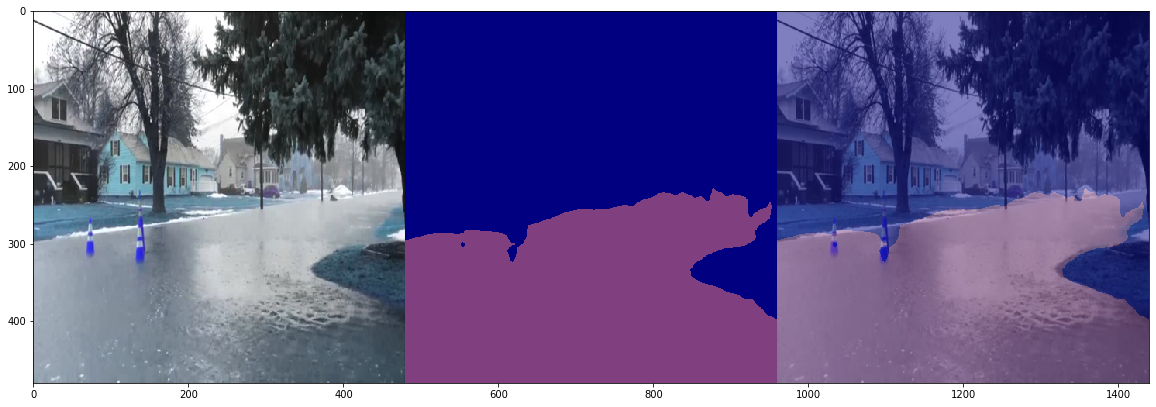

In [51]:
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("No checkpoint in the path.")
        
        
im1 = np.float32(cv2.imread('data/flood/test/0100/img.png'))

if im1.shape != cfg.INFER_SIZE:
    im1 = cv2.resize(im1, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))
    

results1 = inference(im1)


overlap_results1 = 0.5 * im1 + 0.5 * results1[0]
vis_im1 = np.concatenate([im1/255.0, results1[0]/255.0, overlap_results1/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im1)
    

    

## Reference
#### Tensorflow2.0: (官網寫得很好)

https://www.tensorflow.org/guide/effective_tf2 (官網)

https://www.tensorflow.org/api_docs/python/tf (官網API)

其他人整理過的解說:

https://medium.com/@penolove15/%E8%AD%AF-tensorflow-2-0-a1bd38c5cd1e

https://ithelp.ithome.com.tw/articles/10217648

https://zhuanlan.zhihu.com/p/50049041


#### ICNet:

https://github.com/hszhao/ICNet (ICNet作者github)

https://github.com/hellochick/ICNet-tensorflow (hellochick寫的Tensorflow 1.x的版本)

https://arxiv.org/abs/1704.08545 (ICNet paper)


